The objective of this update is to build an uncertainty model and summarize local uncertainty

1. Calculate the uncertainty in facies proportions and average porosity with bootstrap. Use 'n effective', instead of 'n' to account for spatial continuity.
2. Propagate the uncertainty in facies proportions and porosity average to porosity realizations.
3. Calculate and summarize the local uncertainty in oil in place. Assume the same constants as update #2, thickness of 20m and oil saturation of 90%. Include the local P10, expectation and P90 maps.

# 1. Import packages and load dataset



In [45]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python      
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
from scipy.stats import norm
import random
import math
import scipy.signal as signal  
import pprint
import scipy
import scipy.linalg                       # linear algebra library

In [46]:
df = pd.read_csv('8_sample_data.csv')     # load our data table

Plotting parameters

In [47]:
pormin = 0.05; pormax = 0.25
permmin = 0.01; permmax = 1000;                # user specified min and max
AImin = 1000.0; AImax = 6000
Fmin = 0; Fmax = 1

xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25
permmin = 0.01; permmax = 300;                # user specified min and max
AImin = 1000.0; AImax = 6000
Fmin = 0; Fmax = 1
cmap = plt.cm.plasma                    # color map

In [48]:
nx = 100; ny = 100; csize = 10.0
xsiz = 10; ysiz = 10
xmn = 5; ymn = 5

In [49]:
df['logPerm'] = np.log(df['Perm'].values)

In [50]:
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
count,168.000000,168.000000,168.00000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,207.767857,514.345238,465.87500,0.666667,0.153916,77.403572,3396.279944,2.407377
std,114.277788,290.006483,286.99991,0.472814,0.034007,202.949762,748.991891,2.299734
min,3.000000,0.000000,20.00000,0.000000,0.080884,0.046707,1189.857907,-3.063857
25%,104.000000,260.000000,209.00000,0.000000,0.130374,2.889615,2923.281779,1.060944
50%,216.500000,490.000000,439.50000,1.000000,0.150119,12.088688,3456.145034,2.492266
75%,306.750000,780.000000,729.00000,1.000000,0.177243,65.522793,3957.836990,4.179527
max,381.000000,990.000000,979.00000,1.000000,0.249454,2056.729133,5186.291314,7.628872


In [51]:
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records

In [52]:
df_sand.describe()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
count,112.000000,112.000000,112.000000,112.000000,112.0,112.000000,112.000000,112.000000,112.000000
mean,81.035714,201.937500,516.428571,408.142857,1.0,0.165880,110.068496,3109.814779,3.146478
std,48.390106,113.631955,276.984590,278.284832,0.0,0.032048,241.522616,693.915972,2.053242
min,1.000000,5.000000,0.000000,20.000000,1.0,0.083737,0.156970,1189.857907,-1.851699
25%,40.750000,102.000000,297.500000,160.000000,1.0,0.143944,4.987704,2584.387646,1.602526
50%,76.500000,198.000000,490.000000,369.500000,1.0,0.166589,27.870215,3223.929842,3.327339
75%,124.500000,305.250000,770.000000,634.250000,1.0,0.186953,114.014701,3597.645230,4.736313
max,167.000000,381.000000,980.000000,979.000000,1.0,0.249454,2056.729133,4536.067943,7.628872


In [53]:
df_shale.describe()

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
count,56.000000,56.000000,56.000000,56.000000,56.0,56.000000,56.000000,56.000000,56.000000
mean,88.428571,219.428571,510.178571,581.339286,0.0,0.129989,12.073724,3969.210274,0.929176
std,49.205268,115.698960,317.028769,271.012061,0.0,0.023757,28.605079,479.840085,2.052602
min,0.000000,3.000000,60.000000,20.000000,0.0,0.080884,0.046707,2851.868733,-3.063857
25%,42.500000,107.000000,180.000000,439.750000,0.0,0.114131,0.424355,3681.067809,-0.857292
50%,97.000000,247.000000,500.000000,650.000000,0.0,0.128121,3.894984,3957.468966,1.358185
75%,125.500000,308.500000,840.000000,781.500000,0.0,0.142070,9.739336,4261.175382,2.275577
max,166.000000,380.000000,990.000000,979.000000,0.0,0.202176,188.228096,5186.291314,5.237655


# 2. Spatial bootstrap

First, we did spatial bootstrap for facies proportions. For this, we first need to calculate n_effective for facies proportion.

In [54]:
from numba import jit # for numerical speed up

@jit(nopython=True)
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

@jit(nopython=True)
def setup_rotmat(c0, nst, it, cc, ang, pmx):
    """Setup rotation matrix.
    :param c0: nugget constant (isotropic)
    :param nst: number of nested structures (max. 4)
    :param it: TODO
    :param cc: multiplicative factor of each nested structure
    :param ang: TODO
    :param pmx: TODO
    :return: TODO
    """
    PI = 3.141_592_65
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def n_effective(df,xcol,ycol,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param df: source DataFrame
    :param xcol: column with the X locations
    :param ycol: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff
    

In [55]:
vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.65,azi1=157.5,hmaj1=250,hmin1=250,it2=1,cc2=0.25,azi2=157.5,hmaj2=500,hmin2=500)
n_eff_facies = n_effective(df,'X','Y',seed=73073,nreal=1000,vario=vario)
print(n_eff_facies)

11.699847746217612


In [56]:
vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200)
n_eff_sand = n_effective(df_sand,'X','Y',seed=73074,nreal=1000,vario=vario)
print(n_eff_sand)

19.747502674096012


In [57]:
vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200)
n_eff_shale = n_effective(df_shale,'X','Y',seed=73075,nreal=1000,vario=vario)
print(n_eff_shale)

15.820655896440543



n_effective for facies proportion is 12. n_effective for sand porosity is 20. n_effective for shale porosity is 16.


In [58]:
print("declustering porosity:")
wts_porosity, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts_porosity'] = wts_porosity # add weights to the sample data DataFrame

print("declustering porosity:")
wts_porosity, cell_sizes, dmeans = geostats.declus(df_sand,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df_sand['Wts_porosity'] = wts_porosity # add weights to the sample data DataFrame

print("declustering porosity:")
wts_porosity, cell_sizes, dmeans = geostats.declus(df_shale,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df_shale['Wts_porosity'] = wts_porosity # add weights to the sample data DataFrame

declustering porosity:
There are 168 data with:
   mean of      0.15391629523632155 
   min and max  0.0808837694350806 and 0.2494536799448483
   standard dev 0.033906041125275496 
declustering porosity:
There are 112 data with:
   mean of      0.1658798001071648 
   min and max  0.0837365229630927 and 0.2494536799448483
   standard dev 0.031904599706188794 
declustering porosity:
There are 56 data with:
   mean of      0.12998928549463504 
   min and max  0.0808837694350806 and 0.20217630094053
   standard dev 0.02354355998514654 


In [59]:
L = 1000                                   # set the number of realizations
n_eff=12
mean_facies = np.zeros(L); stdev_facies = np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df['Facies'].values, weights=df['Wts_porosity'].values, cum_weights=None, k=n_eff)
    mean_facies[l] = np.average(samples)
    stdev_facies[l] = np.std(samples)

facies_mean=np.average(mean_facies)
facies_std=np.average(stdev_facies)
print('Summary Statistics for Bootstrap Facies Proportion Mean Realizations:')
print(stats.describe(mean_facies))

print('\nSummary Statistics for Bootstrap Facies Proportion Standard Deviation Realizations:')
print(stats.describe(stdev_facies))


Summary Statistics for Bootstrap Facies Proportion Mean Realizations:
DescribeResult(nobs=1000, minmax=(0.16666666666666666, 1.0), mean=0.6219166666666667, variance=0.018675835557779998, skewness=-0.009987937993928305, kurtosis=-0.3221172414353384)

Summary Statistics for Bootstrap Facies Proportion Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(0.0, 0.5), mean=0.4624867331847639, variance=0.002587776070822489, skewness=-2.5089833959002537, kurtosis=9.845184296901865)


Next, we repeat the same steps for sand and shale porosity

In [60]:
L = 1000                                   # set the number of realizations
n_eff=20
mean_sand = np.zeros(L); stdev_sand= np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df_sand['Porosity'].values, weights=df_sand['Wts_porosity'].values, cum_weights=None, k=n_eff)
    mean_sand[l] = np.average(samples)
    stdev_sand[l] = np.std(samples)

sand_mean=np.average(mean_sand)
sand_std=np.average(stdev_sand)
print('Summary Statistics for Bootstrap Sand Porosity Mean Realizations:')
print(stats.describe(mean_sand))

print('\nSummary Statistics for Bootstrap Porosity Standard Deviation Realizations:')
print(stats.describe(stdev_sand))

L = 1000                                   # set the number of realizations
n_eff=16
mean_shale = np.zeros(L); stdev_shale= np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df_shale['Porosity'].values, weights=df_shale['Wts_porosity'].values, cum_weights=None, k=n_eff)
    mean_shale[l] = np.average(samples)
    stdev_shale[l] = np.std(samples)

shale_mean=np.average(mean_shale)
shale_std=np.average(stdev_shale)
print('Summary Statistics for Bootstrap Shale Porosity Mean Realizations:')
print(stats.describe(mean_shale))

print('\nSummary Statistics for Bootstrap Shale Porosity Standard Deviation Realizations:')
print(stats.describe(stdev_shale))

Summary Statistics for Bootstrap Sand Porosity Mean Realizations:
DescribeResult(nobs=1000, minmax=(0.13507394731200817, 0.17897676057943998), mean=0.15749489409785794, variance=4.646844728073327e-05, skewness=-0.060743477489157774, kurtosis=0.06358587994628495)

Summary Statistics for Bootstrap Porosity Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(0.012684360017290272, 0.044638613001817526), mean=0.029266689812568723, variance=2.486160187553952e-05, skewness=0.06721500051559623, kurtosis=-0.08006304590573299)
Summary Statistics for Bootstrap Shale Porosity Mean Realizations:
DescribeResult(nobs=1000, minmax=(0.11374559406291022, 0.14995016859606952), mean=0.1283133198886033, variance=2.9434391875462147e-05, skewness=0.23649266306739458, kurtosis=0.08133332712672292)

Summary Statistics for Bootstrap Shale Porosity Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(0.009376722034873445, 0.035869166539688066), mean=0.020810949636004026, variance=2.3

# 3. Construct scenarios for facies proportion and average porosity

For this, we sample from the bootstrapped result randomly to construct 10 scenarios for facies proportion and average porosity

In [61]:
n_scenario=10
facies_means=np.zeros(n_scenario)
facies_std=np.zeros(n_scenario)
sand_means=np.zeros(n_scenario)
sand_std=np.zeros(n_scenario)
shale_means=np.zeros(n_scenario)
shale_std=np.zeros(n_scenario)
for i in range(n_scenario):
    facies_means[i]=np.percentile(mean_facies,random.random()*100)
    facies_std[i]=np.percentile(stdev_facies,random.random()*100)
    sand_means[i]=np.percentile(mean_sand,random.random()*100)
    sand_std[i]=np.percentile(stdev_sand,random.random()*100)  
    shale_means[i]=np.percentile(mean_shale,random.random()*100)
    shale_std[i]=np.percentile(stdev_shale,random.random()*100)  

In [63]:
print(facies_means)

[0.58333333 0.75       0.5        0.75       0.58333333 0.75
 0.66666667 0.66666667 0.58333333 0.66666667]


In [65]:
print(facies_std)

[0.4330127  0.4330127  0.49300665 0.5        0.47140452 0.4330127
 0.47140452 0.49300665 0.49300665 0.5       ]


# 4. Facies and porosity realizations

In [66]:
facies_grid = GSLIB.DataFrame2ndarray(df,'X','Y','Facies',xmin, xmax, ymin, ymax, csize)

We have made a kernel of size, number of grid cells (ny, nx) (53, 53)


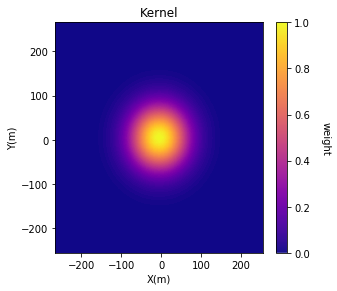

In [67]:
gkern1d = signal.gaussian(53,5).reshape(53, 1)
gkern2d = np.outer(gkern1d, gkern1d)
print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape))

plt.subplot(111)
GSLIB.pixelplt_st(gkern2d,xmin=-265,xmax=265,ymin=-265,ymax=265,step=10,vmin=0,vmax=1,title='Kernel',xlabel='X(m)',ylabel='Y(m)',vlabel='weight',cmap=cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

In [68]:
import astropy.convolution.convolve as convolve
sand_trend_original = convolve(facies_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)

Next, we construct 10 simulations for each scenario

In [71]:
# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 400; skmean = 0
tmin = -999; tmax = 999

ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
varios_facies = []                                # the variogram list
varios_facies.append(GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.65,azi1=157.5,hmaj1=250,hmin1=250,it2=1,cc2=0.25,azi2=157.5,hmaj2=500,hmin2=500)) # shale indicator variogram
varios_facies.append(GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.65,azi1=157.5,hmaj1=250,hmin1=250,it2=1,cc2=0.25,azi2=157.5,hmaj2=500,hmin2=500)) # sand indicator variogram

n_realization=10
sim_ik=[]
for i in range(n_scenario):
    gcdf = [1-facies_means[i],facies_means[i]] # the global proportions of the categories
    sim_ik_sc=[]
    sand_trend=GSLIB.affine(sand_trend_original, facies_means[i], facies_std[i])
    facies_trend=np.zeros((np.shape(sand_trend)[0],np.shape(sand_trend)[1],2))
    facies_trend[:,:,0] = 1-sand_trend
    facies_trend[:,:,1] = sand_trend
    facies_trend = geostats.correct_trend(facies_trend)    
    for j in range(n_realization):
        sim_ik_sc.append(geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=facies_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073+i+j+i*j,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,radius=radius,ktype=0,vario=varios_facies))
    sim_ik.append(sim_ik_sc)

Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73073
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73074
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73075
   currently on node 0
   c

Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73075
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73078
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73081
   currently on node 0
   c

Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73077
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73082
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73087
   currently on node 0
   c

Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73079
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73086
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73093
   currently on node 0
   c

Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73081
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73090
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 168
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73099
   currently on node 0
   c

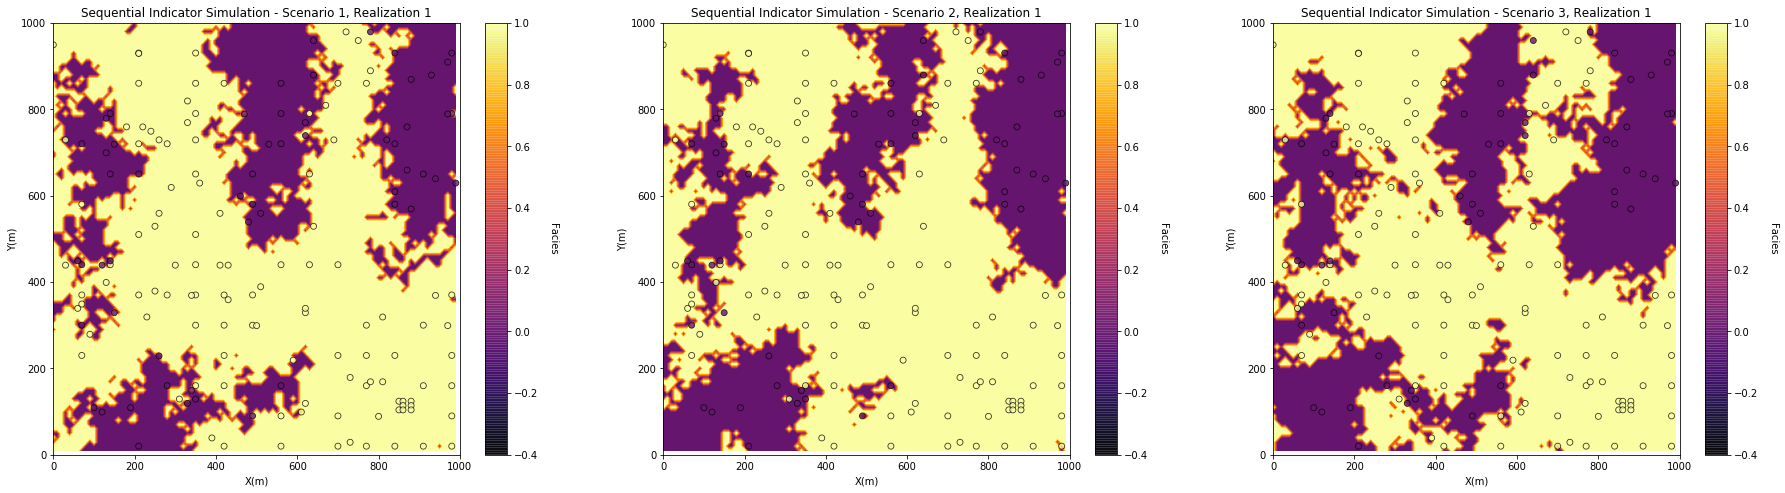

In [72]:
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno # plotting parameters

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(sim_ik[0][0],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Scenario 1, Realization 1','X(m)','Y(m)','Facies',cmap)

plt.subplot(132)                                          # plot the results
GSLIB.locpix_st(sim_ik[1][0],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Scenario 2, Realization 1','X(m)','Y(m)','Facies',cmap)

plt.subplot(133)                                          # plot the results
GSLIB.locpix_st(sim_ik[2][0],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Scenario 3, Realization 1','X(m)','Y(m)','Facies',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

Next, we simulate porosity realizations.

In [78]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 50; ktype = 2; skmean = 0
por_sand_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.1,nst=2,it1=1,cc1=0.6,azi1=120,hmaj1=200,hmin1=100,it2=1,cc2=0.3,azi2=120,hmaj2=650,hmin2=200) # porosity shale variogram
tmin = -999; tmax = 999

por_sand_sim=[]
por_shale_sim=[]
for i in range(n_scenario):
    por_sand_sim_sc=[]
    por_shale_sim_sc=[]
    for j in range(n_realization):
        trend = np.zeros((ny,nx)); trend.fill(sand_means[i])
        por_sand_sim_sc.append(geostats.sgsim(df_sand,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=60000+i+j+i*j,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=trend,vario=por_sand_vario))
        
        trend = np.zeros((ny,nx)); trend.fill(shale_means[i])
        por_shale_sim_sc.append(geostats.sgsim(df_shale,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=70000+i+j+i*j,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=trend,vario=por_shale_vario))
    por_sand_sim.append(por_sand_sim_sc)
    por_shale_sim.append(por_shale_sim_sc)
    


 Data for SGSIM: Number of acceptable data     = 112
                 Number trimmed                = 0
                 Weighted Average              = 0.1659
                 Weighted Variance             = 0.001
                 Weighted Transformed Average  = -0.0
                 Weighted Transformed Variance = 0.9887
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.1871
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1347 (close to 0.0?)
                                   variance =

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2006 (close to 0.0?)
                                   variance = 0.8406 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.0432
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on r

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2017 (close to 0.0?)
                                   variance = 0.8333 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.0432
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on r

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2375 (close to 0.0?)
                                   variance = 0.8329 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0462
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1743 (close to 0.0?)
                                   variance = 0.7898 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0462
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0338 (close to 0.0?)
                                   variance = 0.8355 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0014
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0427 (close to 0.0?)
                                   variance = 0.8487 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0014
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0547 (close to 0.0?)
                                   variance = 0.7225 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0014
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1494 (close to 0.0?)
                                   variance = 0.9218 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.015
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1387 (close to 0.0?)
                                   variance = 0.7798 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.015
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.3403 (close to 0.0?)
                                   variance = 0.8583 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.4481
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2661 (close to 0.0?)
                                   variance = 0.7288 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.4481
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.429 (close to 0.0?)
                                   variance = 0.9826 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.4481
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on rea

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.3365 (close to 0.0?)
                                   variance = 0.9059 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.4511
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on r

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.304 (close to 0.0?)
                                   variance = 0.8577 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.4511
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2521 (close to 0.0?)
                                   variance = 0.8171 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0122
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.214 (close to 0.0?)
                                   variance = 0.8135 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0122
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on rea

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1329 (close to 0.0?)
                                   variance = 0.7741 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0122
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.196 (close to 0.0?)
                                   variance = 0.7823 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.0021
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2145 (close to 0.0?)
                                   variance = 0.7225 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.0021
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on r

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.164 (close to 0.0?)
                                   variance = 0.8305 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0166
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on rea

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2548 (close to 0.0?)
                                   variance = 0.927 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0166
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on rea

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2157 (close to 0.0?)
                                   variance = 0.8294 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0166
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.2154 (close to 0.0?)
                                   variance = 0.9504 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0197
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.3853 (close to 0.0?)
                                   variance = 0.8064 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 56
                 Number trimmed                = 0
                 Weighted Average              = 0.13
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9776
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.0197
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on re

Next, propogate facies model to porosity simulation by cookie-cutter approach

In [79]:
por_sim=[]

for i in range(n_scenario):
    por_sim_sc=[]
    for j in range(n_realization):
        por_sim_temp=np.zeros((ny,nx))
        for iy in range(0,ny):
            for ix in range(0,nx):
                if sim_ik[i][j][iy,ix] ==1:   # current location is assumed to be sand     
                    por_sim_temp[iy,ix] = por_sand_sim[i][j][iy,ix];    
                    por_shale_sim[i][j][iy,ix] = -1
                else:                      # current location is assumed to be shale
                    por_sim_temp[iy,ix] = por_shale_sim[i][j][iy,ix];
                    por_sand_sim[i][j][iy,ix] = -1
        por_sim_sc.append(por_sim_temp)
    por_sim.append(por_sim_sc)

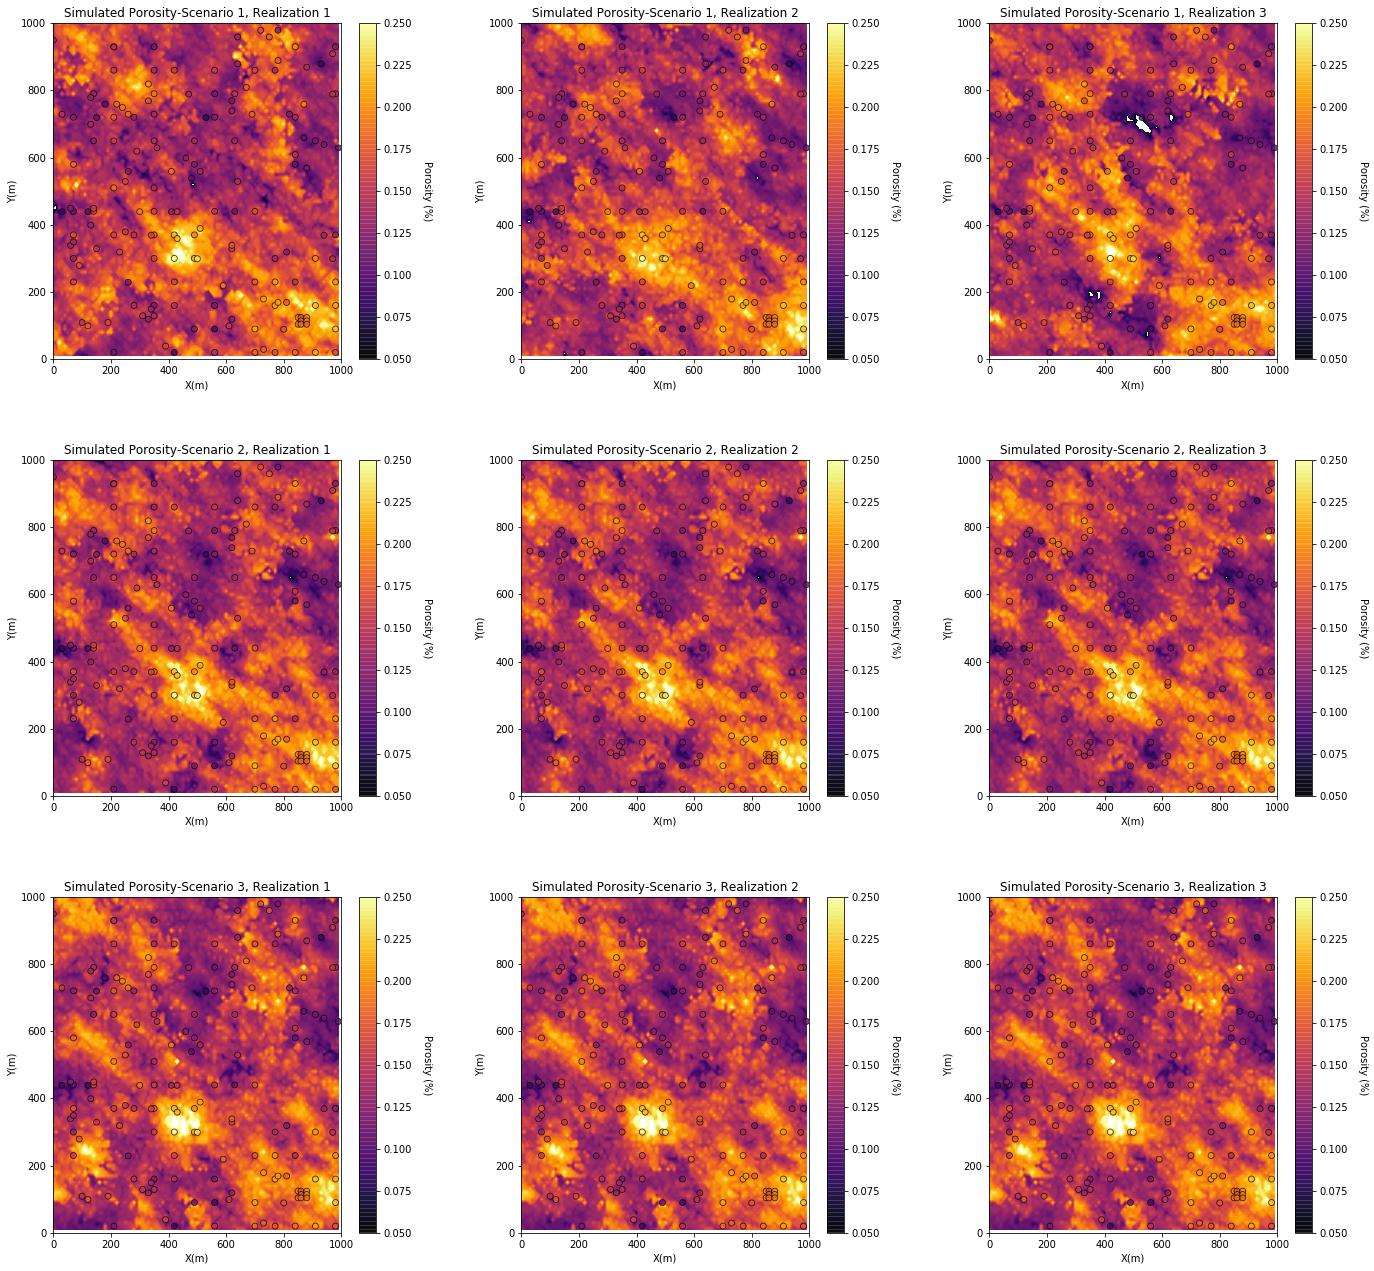

In [80]:
plt.subplot(331)
GSLIB.locpix_st(por_sim[0][0],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 1, Realization 1','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(332)
GSLIB.locpix_st(por_sim[0][1],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 1, Realization 2','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(333)
GSLIB.locpix_st(por_sim[0][2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 1, Realization 3','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(334)
GSLIB.locpix_st(por_sim[1][2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 2, Realization 1','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(335)
GSLIB.locpix_st(por_sim[1][2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 2, Realization 2','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(336)
GSLIB.locpix_st(por_sim[1][2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 2, Realization 3','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(337)
GSLIB.locpix_st(por_sim[2][2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 3, Realization 1','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(338)
GSLIB.locpix_st(por_sim[2][2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 3, Realization 2','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(339)
GSLIB.locpix_st(por_sim[2][2],xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Simulated Porosity-Scenario 3, Realization 3','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=4.2, wspace=0.3, hspace=0.3)
plt.show()

# 5. Calculate local uncertainty

In [81]:
def local_expectation(realizations):                      # calculate the local expectation / average realization
    cond_exp = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            cond_exp[iy,ix] = np.average(a = realizations[iy,ix,:])  
    return cond_exp

def local_standard_deviation(realizations):               # calculate the local standard deviation of realizations
    local_stdev = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            local_stdev[iy,ix] = np.std(a = realizations[iy,ix,:])  
    return local_stdev
 
def local_percentile(realizations,p_value):               # calculate the local percentile of realizations
    percentile = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            percentile[iy,ix] = np.percentile(a = realizations[iy,ix,:], q = p_value)  
    return percentile

def local_probability_exceedance(realizations,threshold): # calculate the local probability of exceeding a threshold 
    prob_exceed = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            prob_exceed[iy,ix] = np.sum(realizations[iy,ix,:] >= threshold)/realizations[0,0,:].size 
    return prob_exceed

In [85]:
por_realization=np.zeros((ny,nx,n_scenario*n_realization))
for i in range(n_scenario):
    for j in range(n_realization):
        por_realization[:,:,i*n_realization+j]=por_sim[i][j]                      

In [88]:
e_porosity = local_expectation(por_realization)
local_stdev = local_standard_deviation(por_realization)
localp10_porosity = local_percentile(realizations = por_realization,p_value = 10)
localp90_porosity = local_percentile(realizations = por_realization,p_value = 90)

In [90]:
dx=(xmax-xmin)/nx
dy=(ymax-ymin)/ny
h=20
so=0.9
e_ooip=e_porosity*dx*dy*h*so
localp10_ooip=localp10_porosity*dx*dy*h*so
localp90_ooip=localp90_porosity*dx*dy*h*so

Note that the local OOIP is calculated assuming a gridblock size of 10m by 10m, thickness of 20m and oil saturation of 0.9

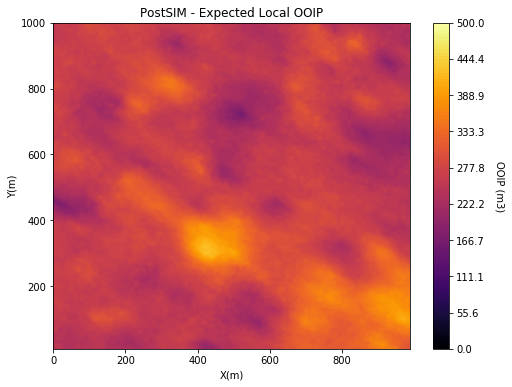

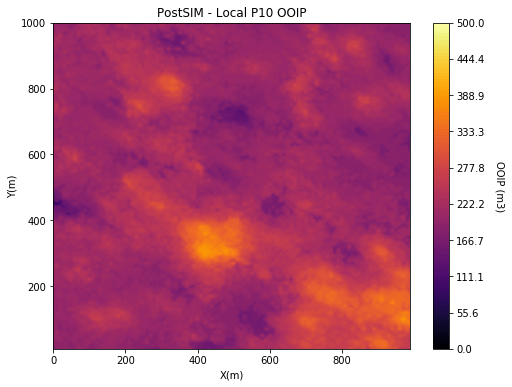

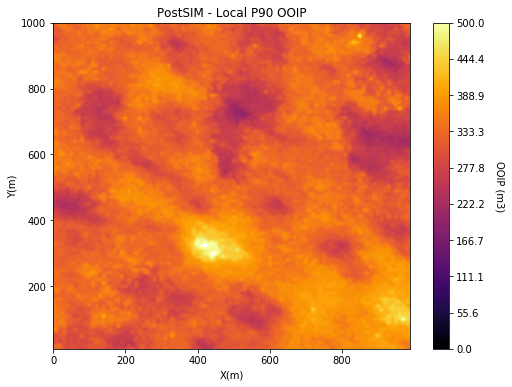

In [99]:
GSLIB.pixelplt(e_ooip,xmin,xmax,ymin,ymax,xsiz,0,500,'PostSIM - Expected Local OOIP','X(m)','Y(m)','OOIP (m3)',cmap,'PostSIM - Expected Local OOIP')

GSLIB.pixelplt(localp10_ooip,xmin,xmax,ymin,ymax,xsiz,0,500,'PostSIM - Local P10 OOIP','X(m)','Y(m)','OOIP (m3)',cmap,'PostSIM - Local P10 OOIP')

GSLIB.pixelplt(localp90_ooip,xmin,xmax,ymin,ymax,xsiz,0,500,'PostSIM - Local P90 OOIP','X(m)','Y(m)','OOIP (m3)',cmap,'PostSIM - Local P90 OOIP')